In [37]:
#define lstm model
import torch
from torch.nn import *
import torch.nn.functional as F
from pandas_datareader import data as web
import os
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [294]:
#Define period time
T = 20

In [295]:
def get_stock(ticker, start_date, end_date, s_window, l_window):
    try:
        #yf.pdr_override()
        df = yf.download(ticker, start=start_date, end=end_date,auto_adjust=False)
        #print("DF: ",df)
# can use this as well        df = web.get_data_yahoo(ticker, start=start_date, end=end_date)
        df['Return'] = df['Adj Close'].pct_change()
        df['Return'].fillna(0, inplace = True)
        df['Date'] = df.index
        df['Date'] = pd.to_datetime(df['Date'])
        df['Month'] = df['Date'].dt.month
        df['Year'] = df['Date'].dt.year 
        df['Day'] = df['Date'].dt.day
        for col in ['Open', 'High', 'Low', 'Close', 'Adj Close']:
            df[col] = df[col].round(2)
        df['Weekday'] = df['Date'].dt.day_name()
        df['Week_Number'] = df['Date'].dt.strftime('%U')
        df['Year_Week'] = df['Date'].dt.strftime('%Y-%U')
        df['Short_MA'] = df['Adj Close'].rolling(window=s_window, min_periods=1).mean()
        df['Long_MA'] = df['Adj Close'].rolling(window=l_window, min_periods=1).mean()        
        col_list = ['Date', 'Year', 'Month', 'Day', 'Weekday', 
                    'Week_Number', 'Year_Week', 'Open', 
                    'High', 'Low', 'Close', 'Volume', 'Adj Close',
                    'Return', 'Short_MA', 'Long_MA']
        num_lines = len(df)
        df = df[col_list]
        print('read ', num_lines, ' lines of data for ticker: ' , ticker)
        return df
    except Exception as error:
        print(error)
        return None

In [121]:
long_atr = None

In [296]:
def tt_split(df_n,vol_metric,scaler:StandardScaler):
    train = df_n.loc[[i<=len(df_n)*4/5 for i in range(len(df_n))]]
    X_train = train[["index","Open","Close","High","Low"]].to_numpy()
    y_train = train[vol_metric].to_numpy()
    y_train = scaler.fit_transform(y_train.reshape(-1,1))
    #long_atr = y_train.mean()
    X_train = np.concatenate((X_train,y_train),axis=1)

    test = df_n.loc[[i>len(df_n)*4/5 for i in range(len(df_n))]]
    X_test = test[["index","Open","Close","High","Low", vol_metric]].to_numpy()
    y_test = test[vol_metric].to_numpy()
    
    y_test = scaler.transform(y_test.reshape(-1,1))
    X_test = np.concatenate((X_test,y_test),axis=1)
    return X_train,y_train,X_test,y_test
    

#X_train,y_train,X_test,y_test = tt_split(df_n,"ATR_normalized")

#bollinger bands
#try moving median instead of moving average
#try moving quartiles instead of std; q3-q2  *1/2
#take longer time period - five years

#lstm,cnn,and rnn cant either predict directional volatiliy for xl stocks


In [297]:
def make_seq(X_train,y_train,X_test,y_test):
    #T = 30  # sequence length (window size)
    X_seq = []
    y_seq = []
    X_seq_test = []
    y_seq_test = []

    for i in range(len(X_train) - T):
        X_seq.append(X_train[i:i+T])  # shape: [T, 6] <- what is wanted in lstm
        y_seq.append(y_train[i+T])    # predict next ATR value
    for i in range(len(X_test)-T):    
        X_seq_test.append(X_test[i:i+T])
        y_seq_test.append(y_test[i+T])


    X_seq = torch.tensor(X_seq, dtype=torch.float32)
    y_seq = torch.tensor(y_seq, dtype=torch.float32)#.unsqueeze(1)
    X_seq_test = torch.tensor(X_seq_test, dtype=torch.float32)
    y_seq_test = torch.tensor(y_seq_test, dtype=torch.float32)#.unsqueeze(1)
    
    return X_seq,y_seq,X_seq_test,y_seq_test
#X_seq,y_seq,X_seq_test,y_seq_test = make_seq(X_train,y_train,X_test,y_test)

In [298]:
def create_loaders(X_seq,y_seq,X_seq_test,y_seq_test,batch_size=64):
    dataset = TensorDataset(X_seq, y_seq)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    dataset_test = TensorDataset(X_seq_test,y_seq_test)
    loader_test = DataLoader(dataset_test,batch_size=batch_size,shuffle=True)
    return loader,loader_test
#loader,loader_test = create_loaders(X_seq,y_seq,X_seq_test,y_seq_test)

In [299]:
#define lstm model

class NN_LSTM(Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.lstm = LSTM(input_size=input_size,hidden_size=30)
        self.fc = Linear(30,output_size)
    def activation(self,X):
        return F.relu(X)
    def forward(self,input):
        input,_ = self.lstm(input)
        input = self.fc(input[-1,:,:])
        #print(input.shape)
        return input #return the last prediction
#lstm_layer = LSTM(input_size=4,hidden_size=30)

In [300]:
def PDE_loss(t,atr,long_atr,k=3):
    #da/dt = k(theta-atr)
    da_dt = torch.autograd.grad(outputs= atr,inputs= t,grad_outputs=torch.ones_like(atr),create_graph=True)
    return da_dt-k*(long_atr-atr)

In [301]:
def get_cleaned_df(ticker,start,end):
    df = get_stock(ticker,start_date=start,end_date=end,s_window=14,l_window=50)
    df_n= df.xs(ticker,axis=1,level=1)
    
        #define ATR columns
    high = df_n["High"]
    low = df_n["Low"]
    close = df_n["Close"]

    prev_close = close.shift(1)


    tr = pd.concat([
        high - low,
        (high - prev_close).abs(),
        (low - prev_close).abs()
    ], axis=1).max(axis=1)

    df_n["ATR"] = tr.rolling(7).mean()
    
    log_diff = np.log(df_n["Close"]/df_n["Close"].shift(1))
    df_n["SD_Log_Close"] = log_diff.rolling(7).std()
    df_n["ATR_normalized"] = (df_n["ATR"] - df_n["ATR"].mean())/df_n["ATR"].std()
    df_n["SD_normalized"] = (df_n["SD_Log_Close"] - df_n["SD_Log_Close"].mean())/df_n["SD_Log_Close"].std()

    df_n = df_n.dropna()
    df_n = df_n.reset_index().reset_index()
    df_n["index"] = df_n.index%7
    return df_n

In [302]:
def get_trained_model(df,scaler,metric="ATR"):
    X_train,y_train,X_test,y_test = tt_split(df, metric,scaler)


    X_seq,y_seq,X_seq_test,y_seq_test = make_seq(X_train,y_train,X_test,y_test)

    loader,loader_test = create_loaders(X_seq,y_seq,X_seq_test,y_seq_test)

    #training loop
    
    model = NN_LSTM(input_size=6,output_size=1)
    epochs = 20
    optim = torch.optim.Adam(params = model.parameters())
    crit = MSELoss()
    pde_crit = MSELoss()
    losses = []

    for i in range(epochs):
        running_loss = 0
        for x_window,y_atr in loader:
            #print("Running")
            input = x_window.permute(1,0,2) #shape = [seq_length,batch_length,4]
            #t = input[-1][:,0]
            
            out = model(input)
            #print(y_atr.shape)
            #print(out,y_atr)
            #break
            #print("T shape: ",t.shape)
            loss = crit(out,y_atr)# + pde_crit(PDE_loss(t,out,long_atr))
            running_loss+=loss.item()
            optim.zero_grad()
            loss.backward()
            optim.step()
                # could try loss += (i+1)/period/sum(j/period for j in range(period))crit(out,y_train[i]); adds a coeff to give more weigt to recent ones
        #break
        running_loss/=(len(loader))
        print(f"Epoch {i+1} | Training Loss: {running_loss}")
        losses.append(running_loss)

    sns.lineplot(x=[i for i in range(len(losses))],y=losses)
    plt.title(f"Training Loss of LSTM ({metric}) across {epochs} epochs for {ticker}")
    plt.show()
    return model
    

In [313]:

def backtest_strategy(data: pd.DataFrame,
                          lstm_model,
                          scaler:StandardScaler,
                          vol_metric:str,
                          ini_cash=10000,
                          R: float = 1000.0,
                          upper_scale = 1.5,
                          lower_scale = 1.5):
    """
    Backtest a simple ATR‑based mean‑reversion strategy:
      - Predict next ATR with an LSTM
      - If predicted ATR is unusually high → go flat (sell)
      - If unusually low → go long
    Assumes 'data' has columns ['index','Open','High','Low','Close',vol_metric].
    'scaler' is a fitted StandardScaler on the train-period ATR.
    """
    cash = ini_cash
    shares = 0.0

    buys = []
    sells = []
    preds = []
    passive_shares = ini_cash/data.loc[T,"Open"]
    # Precompute rolling IQR thresholds on ATR over T bars
    # (we’ll compute quantiles on‑the‑fly inside the loop)
    for i in range(T, len(data)-1):
        window_atr = data[vol_metric].iloc[i-T:i]
        q1 = window_atr.quantile(0.25)
        q3 = window_atr.quantile(0.75)
        med = window_atr.quantile(0.50)
        iqr = q3 - q1
        lower = med - upper_scale * iqr
        upper = med + lower_scale * iqr

        # Prepare model input: last T bars of OHLC + normalized ATR
        X = data[['index','Open','High','Low','Close']].iloc[i-T:i].copy()
        X['ATR_norm'] = scaler.transform(data[[vol_metric]].iloc[i-T:i])  # shape (T,1)
        # reshape to (1, T, features)
        #print(X)
        model_in = torch.tensor(X.values.reshape(T,1, X.shape[1])).to(torch.float32)
        # Predict next normalized ATR, then denormalize
        atr_next_norm = lstm_model(model_in)
        #print(atr_next_norm.shape)
        atr_next_norm=atr_next_norm.item()
        atr_next = scaler.inverse_transform([[atr_next_norm]])[0,0]
        preds.append(atr_next)

        # next bar’s prices
        open_next  = data['Open'].iloc[i+1]
        close_next = data['Close'].iloc[i+1]

        # entry/exit signals
        if atr_next > upper and shares > 0:
            sells.append(i)
            # sell all
            cash += shares * close_next
            print(f"On the {i}th day, sold {shares} shares for ${shares*close_next}")
            shares = 0.0
            
        elif atr_next < lower:
            # buy: risk R = shares * ATR_next -> shares = R / ATR_next
            target_shares = R / atr_next
            # adjust cash & position
            delta = max(target_shares - shares,0)
            if cash<delta*open_next:
                for j in range(int(delta)):
                    if cash>j*open_next:
                        delta = j
            cash -= delta * open_next
            shares+=delta
            print(f"On the {i}th day, Bought {delta} shares for ${delta*open_next}")
            buys.append(i)

    # At end, mark-to-market at last close
    final_value = cash + shares * data['Close'].iloc[-1]
    passive_value = passive_shares*data['Close'].iloc[-1]
    return final_value, cash, shares,passive_value,buys,sells,preds

In [304]:
def backtest_strategy_del(data: pd.DataFrame,
                          lstm_model,
                          scaler:StandardScaler,
                          vol_metric:str,
                          ini_cash=10000,
                          R: float = 1000.0,):
    """
    Backtest a simple ATR‑based mean‑reversion strategy:
      - Predict next ATR with an LSTM
      - If predicted ATR is unusually high → go flat (sell)
      - If unusually low → go long
    Assumes 'data' has columns ['Open','High','Low','Close','ATR'].
    'scaler' is a fitted StandardScaler on the train-period ATR.
    """
    cash = ini_cash
    shares = 0.0

    buys = []
    sells = []
    preds = []
    passive_shares = ini_cash/data.loc[T,"Open"]
    # Precompute rolling IQR thresholds on ATR over T bars
    # (we’ll compute quantiles on‑the‑fly inside the loop)
    for i in range(T, len(data)-1):
        window_atr = data[vol_metric].iloc[i-T:i]
        q1 = window_atr.quantile(0.25)
        q3 = window_atr.quantile(0.75)
        med = window_atr.quantile(0.50)
        iqr = q3 - q1
        lower = med - 1.5 * iqr
        upper = med + 1.5 * iqr

        # Prepare model input: last T bars of OHLC + normalized ATR
        X = data[['index','Open','High','Low','Close']].iloc[i-T:i].copy()
        X[vol_metric] = scaler.transform(data[[vol_metric]].iloc[i-T:i])  # shape (T,1)
        # reshape to (1, T, features)
        #print(X)
        model_in = torch.tensor(X.values.reshape(T,1, X.shape[1])).to(torch.float32)
        # Predict next normalized ATR, then denormalize
        atr_next_norm = lstm_model(model_in)
        #print(atr_next_norm.shape)
        atr_next_norm=atr_next_norm.item()
        atr_next = scaler.inverse_transform([[atr_next_norm]])[0,0]
        atr_prev=med
        if i != T:
            atr_prev = preds[-1]
        preds.append(atr_next)
        # next bar’s prices
        open_next  = data['Open'].iloc[i+1]
        close_next = data['Close'].iloc[i+1]

        # entry/exit signals
        if atr_next-atr_prev > .75*iqr and shares > 0:
            sells.append(i)
            # sell all
            cash += shares * close_next
            print(f"On the {i}th day, sold {shares} shares for ${shares*close_next}")
            shares = 0.0
            
        elif atr_next-atr_prev<-.75*iqr:
            # buy: risk R = shares * ATR_next -> shares = R / ATR_next
            target_shares = R / atr_next
            # adjust cash & position
            delta = max(target_shares - shares,0)
            if cash<delta*open_next:
                for j in range(int(delta)):
                    if cash>j*open_next:
                        delta = j
            cash -= delta * open_next
            shares+=delta
            print(f"On the {i}th day, Bought {delta} shares for ${delta*open_next}")
            buys.append(i)

    # At end, mark-to-market at last close
    final_value = cash + shares * data['Close'].iloc[-1]
    passive_value = passive_shares*data['Close'].iloc[-1]
    return final_value, cash, shares,passive_value,buys,sells,preds

In [305]:
def get_model_preds(df:pd.DataFrame,model,scaler,vol_metric="ATR"):
    preds = []
    #T=30
    for i in range(T, len(df)-1):
        df_window = df[["index","Open","Close","High","Low"]].iloc[i-T:i]
        df_window[vol_metric] = scaler.transform(df[[vol_metric]].iloc[i-T:i])  # shape (T,1)
        df_window = df_window.values.reshape(T,1,6) #6 is number of features
        
        input = torch.tensor(df_window,dtype=torch.float32)
        pred = scaler.inverse_transform([[model(input).item()]])[0,0]
        preds.append(pred)
    return preds

In [306]:
ticker = 'XLY'
start = '2001-01-01'
end = '2022-07-07'
start_n = '2023-01-01'
end_n = '2024-01-01'
data = get_cleaned_df(ticker,start,end)

[*********************100%***********************]  1 of 1 completed

read  5411  lines of data for ticker:  XLY


Epoch 1 | Training Loss: 0.8459941639619715
Epoch 2 | Training Loss: 0.4458641673931304
Epoch 3 | Training Loss: 0.22418874595314264
Epoch 4 | Training Loss: 0.16705202234580235
Epoch 5 | Training Loss: 0.13530293134424617
Epoch 6 | Training Loss: 0.1251740126925356
Epoch 7 | Training Loss: 0.10567549457225729
Epoch 8 | Training Loss: 0.10098512467983015
Epoch 9 | Training Loss: 0.08230006656445124
Epoch 10 | Training Loss: 0.0805461165111731
Epoch 11 | Training Loss: 0.08514633120092399
Epoch 12 | Training Loss: 0.08011965479646974
Epoch 13 | Training Loss: 0.07365735354559387
Epoch 14 | Training Loss: 0.07049288198023158
Epoch 15 | Training Loss: 0.06371457047541351
Epoch 16 | Training Loss: 0.05972746101564125
Epoch 17 | Training Loss: 0.06341727768235347
Epoch 18 | Training Loss: 0.0598150000852697
Epoch 19 | Training Loss: 0.056694597581072766
Epoch 20 | Training Loss: 0.0563200349399053


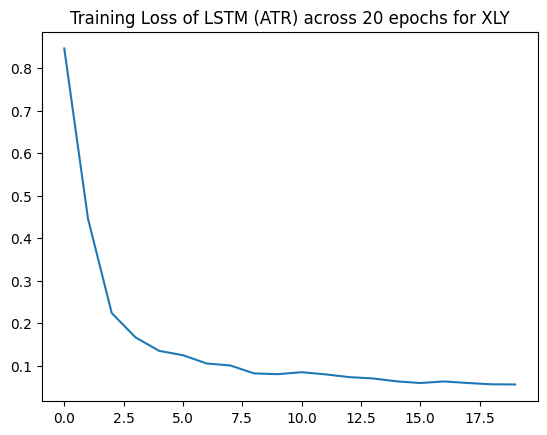

In [307]:
scaler = StandardScaler()
model = get_trained_model(data,scaler = scaler)

Epoch 1 | Training Loss: 0.8298431634902954
Epoch 2 | Training Loss: 0.476704164462931
Epoch 3 | Training Loss: 0.35409843505305405
Epoch 4 | Training Loss: 0.22484067219364293
Epoch 5 | Training Loss: 0.16146183884976542
Epoch 6 | Training Loss: 0.13928258632693222
Epoch 7 | Training Loss: 0.11582800943185301
Epoch 8 | Training Loss: 0.10195726484936826
Epoch 9 | Training Loss: 0.09763248746885973
Epoch 10 | Training Loss: 0.09580567566787496
Epoch 11 | Training Loss: 0.08877843659480705
Epoch 12 | Training Loss: 0.08766723596764837
Epoch 13 | Training Loss: 0.08596518356353045
Epoch 14 | Training Loss: 0.08813512215719503
Epoch 15 | Training Loss: 0.08594639336361605
Epoch 16 | Training Loss: 0.08755402886034812
Epoch 17 | Training Loss: 0.08310291299815564
Epoch 18 | Training Loss: 0.08520326473037987
Epoch 19 | Training Loss: 0.08390135920661337
Epoch 20 | Training Loss: 0.08349563663496691


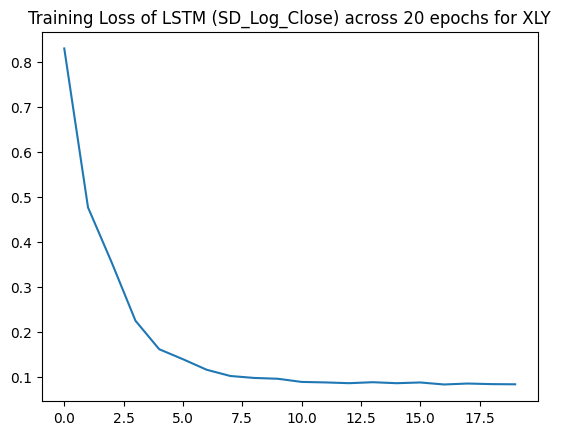

In [288]:
scaler_sd = StandardScaler()
model_sd = get_trained_model(data,scaler = scaler_sd,metric = "SD_Log_Close")

In [ ]:
data_test = get_cleaned_df(ticker,start_n,end_n)

#squares of dail yreturns r_i_i^2

[*********************100%***********************]  1 of 1 completed

read  250  lines of data for ticker:  XLY


In [319]:
final_value, money, shares,passive_value,buy_points,sell_points,atr_preds = backtest_strategy(data_test,model,scaler,"ATR",upper_scale=2,lower_scale=1.3)
print(f"Final Value: {final_value}, Final Money: {money}, Final Shares: {shares}")
print(f"Passive Value {passive_value}")

On the 36th day, Bought 69 shares for $9867.0
On the 37th day, Bought 0 shares for $0.0
On the 38th day, Bought 0 shares for $0.0
On the 39th day, Bought 0 shares for $0.0
On the 40th day, Bought 0 shares for $0.0
On the 41th day, Bought 0 shares for $0.0
On the 42th day, Bought 0 shares for $0.0
On the 43th day, Bought 0 shares for $0.0
On the 44th day, Bought 0 shares for $0.0
On the 46th day, Bought 0 shares for $0.0
On the 47th day, Bought 0 shares for $0.0
On the 54th day, Bought 0 shares for $0.0
On the 55th day, Bought 0 shares for $0.0
On the 56th day, Bought 0 shares for $0.0
On the 57th day, Bought 0 shares for $0.0
On the 67th day, Bought 0 shares for $0.0
On the 68th day, Bought 0 shares for $0.0
On the 69th day, Bought 0 shares for $0.0
On the 70th day, Bought 0 shares for $0.0
On the 71th day, Bought 0 shares for $0.0
On the 76th day, Bought 0 shares for $0.0
On the 79th day, Bought 0 shares for $0.0
On the 80th day, Bought 0 shares for $0.0
On the 81th day, Bought 0 shar

130
141
237


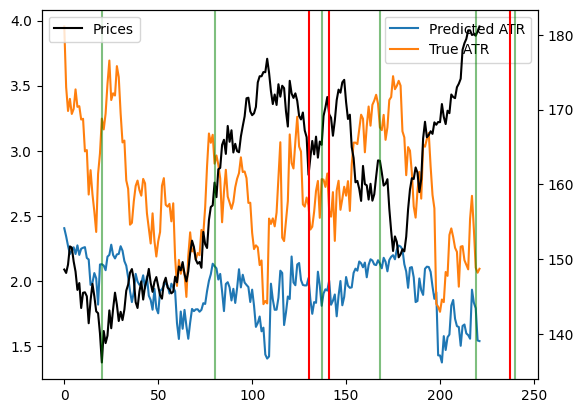

In [318]:
#atr_preds = get_model_preds(data_test,model,scaler)
true_atr = np.array(data_test["ATR"].iloc[T:len(data_test)-1])
prices = np.array(data_test["Open"].iloc[T:len(data_test)-1])
#sns.lineplot(atr_preds_1,color="red")
sns.lineplot(atr_preds,label="Predicted ATR")
sns.lineplot(true_atr,label="True ATR")
ax2 = plt.twinx()
sns.lineplot(prices,label = "Prices",ax=ax2,color="Black")
plt.legend()
for buy in buy_points:
    #print(buy)
    plt.axvline(x=buy,label="Buy",color="Green",alpha = .5)
for sell in sell_points:
    print(sell)
    plt.axvline(x=sell,label="Sell",color="Red")

## Analysis
How can we better capture spikes in ATR?
Can we predict in advance?

In [266]:
final_value_sd, money_sd, shares_sd,passive_value_sd,buy_points_sd,sell_points_sd,sd_preds = backtest_strategy(data_test,model_sd,scaler_sd,"SD_Log_Close")
print(f"Final Value: {final_value_sd}, Final Money: {money_sd}, Final Shares: {shares_sd}")
print(f"Passive Value {passive_value_sd}")

On the 34th day, Bought 24 shares for $9721.2
On the 35th day, Bought 0 shares for $0.0
On the 36th day, Bought 0 shares for $0.0
On the 39th day, sold 24.0 shares for $9248.64
On the 55th day, Bought 23 shares for $9467.26
On the 56th day, Bought 0 shares for $0.0
On the 104th day, Bought 0 shares for $0.0
On the 105th day, Bought 0 shares for $0.0
On the 106th day, Bought 0 shares for $0.0
On the 107th day, Bought 0 shares for $0.0
On the 116th day, Bought 0 shares for $0.0
On the 123th day, Bought 0 shares for $0.0
On the 127th day, Bought 0 shares for $0.0
On the 128th day, Bought 0 shares for $0.0
On the 129th day, Bought 0 shares for $0.0
On the 139th day, sold 23.0 shares for $10276.63
On the 185th day, Bought 23 shares for $9957.62
On the 186th day, Bought 0 shares for $0.0
On the 187th day, Bought 0 shares for $0.0
On the 188th day, Bought 0 shares for $0.0
On the 192th day, Bought 0 shares for $0.0
On the 194th day, sold 23.0 shares for $9670.58
On the 203th day, Bought 23 sh

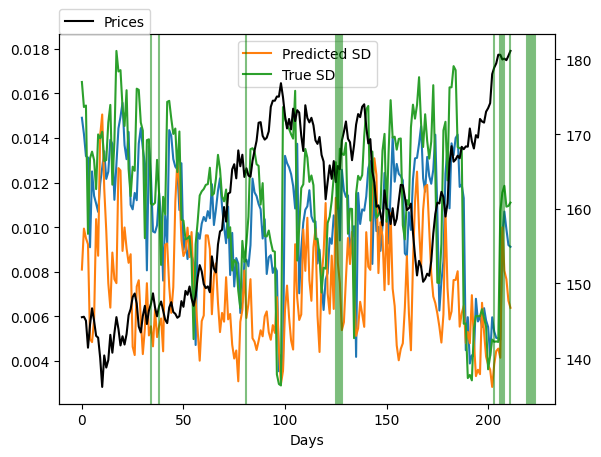

In [291]:
true = np.array(data_test["SD_Log_Close"].iloc[T:len(data_test)-1])
sns.lineplot(get_model_preds(data_test,model_sd,scaler_sd,"SD_Log_Close"))
prices = np.array(data_test["Open"].iloc[T:len(data_test)-1])
sns.lineplot(sd_preds,label="Predicted SD")
sns.lineplot(true,label="True SD")
plt.xlabel("Days")
ax2 = plt.twinx()
sns.lineplot(prices,label = "Prices",ax=ax2,color="Black")
plt.legend(loc=(0,1))
for buy in buy_points:
    #print(buy)
    plt.axvline(x=buy,label="Buy",color="Green",alpha = .5)
for sell in sell_points:
    print(sell)
    plt.axvline(x=buy,label="Sell",color="Red",alpha=.5)